# Libraries

In [6]:
import re
import torch
import numpy as np
import pandas as pd
import tokenizers
from nltk.corpus import stopwords
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, AutoTokenizer, T5Tokenizer
from sklearn.model_selection import train_test_split

# Reading Data

In [7]:
df_squad = pd.read_excel('Arabic squad/Arabic-SQuAD.xlsx')
df_arcd = pd.read_excel('ARCD/arcd-train.xlsx')
df_tydiqa = pd.read_csv('tydiqa/tydiqa-arabic.csv')
df_mlqa = pd.read_excel('MLQA/MLQA-dev-context-ar-question-ar.xlsx')

# Data Overview

In [8]:
df_squad.head()

,id,question,context,answers,c_id
0,570bce516b8089140040fa42,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0
1,570bce516b8089140040fa43,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0
2,570bce516b8089140040fa44,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0
3,570bce516b8089140040fa45,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0
4,570bce516b8089140040fa46,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0


In [9]:
df_squad.shape

(48344, 5)

In [10]:
df_arcd.head()

,id,question,context,answers,c_id
0,969331847966,- من هو جمال أحمد حمزة خاشقجي؟,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'صحفي وإعلامي', 'answer_start': 73}]",0
1,115150665555,- متى ولد جمال أحمد حمزة خاشقجي وتوفي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'حمزة خاشقجي (13 أكتوبر 1958، المدين...,0
2,74212080718,- في أي مدينة ولد جمال أحمد حمزة خاشقجي؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'المدينة المنورة', 'answer_start': 39}]",0
3,465699296586,- في أي صحيفة قام بكتابة عمود منذ عام 2017؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,"[{'text': 'واشنطن بوست', 'answer_start': 224}]",1
4,564177542570,- كيف وصفها في الصحف ووسائل الإعلام الدولية؟ ال,جمال أحمد حمزة خاشقجي (13 أكتوبر 1958، المدينة...,[{'text': 'وُصف في الصحف وأجهزة الاعلام العالم...,1


In [11]:
df_arcd.shape

(693, 5)

In [12]:
df_tydiqa.head()

,id,question,context,answers,c_id
0,arabic-2387335860751143628-1,كم عدد مرات فوز الأوروغواي ببطولة كاس العالم ل...,أقيمت البطولة 21 مرة، شارك في النهائيات 78 دول...,"[{'text': 'بطولتين', 'answer_start': 394}]",0
1,arabic--3358420169913421088-0,من هو مكتشف المرو أو الكوارتز ؟,المرو أو الكوارتز هو معدن يعود اكتشافه إلى ال...,"[{'text': '(بيير كوري) وأخوه (جاك)', 'answer_s...",1
2,arabic-6869798435672288559-0,كيف يتصل الجنين بالرحم ؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,"[{'text': 'عن طريق الحبل السري', 'answer_start...",2
3,arabic-1608369850259830544-0,ما هي المَشِيمَة أو الخَلاَص أو السُخْد؟,المَشِيمَة أو الخَلاَص أو السُخْد (بالإنجليزي...,[{'text': 'عضو دائري مسطح الشكل يتصل بالجنين ع...,2
4,arabic--7165672200361826550-0,أين يقع مسجد السلطان عبد المجيد؟,مسجد السلطان عبد المجيد، هو مسجد أثري تاريخي ف...,"[{'text': 'مدينة جبيل اللبنانية', 'answer_star...",3


In [13]:
df_tydiqa.shape

(921, 5)

In [14]:
df_mlqa.head()

,id,question,context,answers,c_id
0,569666f4dc3983dab5624e989212c1d9d0cd1798,هل تزول الإصابة بمرض ذبابة الرمال عبر الوقت؟,تنتقل حمى الفواصد عن طريق لدغات حشرات من جنس ا...,"[{'text': 'وتبقى مصابة بالفيروس مدى حياتها', '...",0
1,561971f7978f678c3d1ba2a946036cdc131c4d49,ما الذي يتكون بالكامل تقريبا من خلايا نسيجية؟,تعد خلايا متن النبات خلايا حية لديها وظائف متن...,"[{'text': 'الأوراق', 'answer_start': 194}]",1
2,60ee75c50c8472be7cce1a24ee2cd7409ee4dd52,ما اسم نوع الخيوط الذي يحتوي على أجزاء من الكرفس؟,خلايا النسيج الغروي - تعيش خلايا النسيج الغروي...,"[{'text': 'النسيج الغروي.', 'answer_start': 11...",2
3,6a636c91f7733165c92ed84864debf6bdbdf7d16,ما هو ناتج تميز الخلايا النباتية؟,تختلف الطبقات الرئيسية من الخلايا عن الخلايا ا...,[{'text': 'هياكل أنسجة الجذور والسيقان والأورا...,3
4,18a5c05701b7359fcd32a379b2ac4a9a5d7544de,أي نوع من النباتات يحتوي على النسيج الوعائي ال...,تكون خلايا النسيج الوعائي الخشبي خلايا مطولةً...,"[{'text': 'تراشيوفيت', 'answer_start': 320}]",4


In [15]:
df_mlqa.shape

(517, 5)

In [ ]:
df_squad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48344 entries, 0 to 48343
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48344 non-null  object
 1   question  48344 non-null  object
 2   context   48344 non-null  object
 3   answers   48344 non-null  object
 4   c_id      48344 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [17]:
df_arcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        693 non-null    int64 
 1   question  693 non-null    object
 2   context   693 non-null    object
 3   answers   693 non-null    object
 4   c_id      693 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 27.2+ KB


In [18]:
df_tydiqa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        921 non-null    object
 1   question  921 non-null    object
 2   context   921 non-null    object
 3   answers   921 non-null    object
 4   c_id      921 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 36.1+ KB


In [19]:
df_mlqa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        517 non-null    object
 1   question  517 non-null    object
 2   context   517 non-null    object
 3   answers   517 non-null    object
 4   c_id      517 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 20.3+ KB


# Removing id column

In [20]:
# TODO: Removing ids column in all datasets

In [21]:
df_squad.drop('id', axis=1, inplace=True)

In [ ]:
df_squad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48344 entries, 0 to 48343
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  48344 non-null  object
 1   context   48344 non-null  object
 2   answers   48344 non-null  object
 3   c_id      48344 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [23]:
df_squad.head(10)

,question,context,answers,c_id
0,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0
1,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0
2,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0
3,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0
4,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0
5,لماذا تم ترميز الرمز بحيث تكون معظم الرموز معًا؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': 'لسهولة تحديد الهوية', 'answer_start...",1
6,كم عدد المراكز في العمودين الأولين؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '32 موضع', 'answer_start': 128}]",1
7,ما الذي قررت اللجنة أنه مهم؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,[{'text': 'دعم الأحرف الهجائية الكبيرة المكونة...,1
8,أين كان الحرف ألف يضع في الموقف؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '41hex', 'answer_start': 757}]",1
9,تم دمج ASCII في ما مجموعة الأحرف الأخرى؟,تم دمج ASCII في مجموعة أحرف ونيكودي كأول 128 ر...,"[{'text': 'ونيكودي', 'answer_start': 28}]",2


# try1

tried to make something but found out it is the same as the original data

In [24]:
# # Assign a unique question_id to each question
# df_squad['question_id'] = df_squad.index

# # Function to get the context and its associated question_ids
# def get_context_question_ids(df):
#     grouped = df.groupby('c_id').agg(
#         context=('context', 'first'),
#         question_ids=('question_id', list)
#     ).reset_index()
#     return grouped

# # Generate the new DataFrame
# C_Q_df = get_context_question_ids(df_squad)

In [25]:
# C_Q_df.head(15)

In [26]:
# # Create a function to get the assigned questions
# def get_assigned_questions(df, c_id):
#     filtered = df[df['c_id'] == c_id]
#     Q = filtered['question'].tolist()
#     A = filtered['answers'].tolist()
#     return Q, A


In [27]:
# training_data = []

# for _, row in C_Q_df.iterrows():
#     context = row['context']
#     question_ids = row['question_ids']
    
#     # For each question_id in the context, fetch the corresponding question
#     for question_id in question_ids:
#         question = df_squad.loc[df_squad['question_id'] == question_id, 'question'].values[0]
#         training_data.append({
#             'context': context,
#             'question': question,
#             'answers': df_squad.loc[df_squad['question_id'] == question_id, 'answers'].values[0]
#         })
        
# training_df = pd.DataFrame(training_data)

In [28]:
# training_df.head(15)

In [29]:
# TODO: Arrange all data frames by their c_id column, to make same context after each other

In [30]:
# TODO: Combine all datasets as they already contain the same columns (pd.concat([df1, df2], ignore_index=True))

# Text Preprocessing

## text cleaning functions

### Normalization

In [31]:
def remove_diacritics(text):
    # remove diacritics from the text as it may confuse the model
    return re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)


### Text cleaning

In [32]:
def remove_non_arabic(text):
    # Remove non-Arabic characters, keeping essential punctuation
    text = re.sub(r'[^\u0600-\u06FF\s؟]', '', text)
    return text

In [33]:
def remove_punk(text):
    # Remove punctuation
    arabic_punctuation = r'[،؛؟…!"#$%&\'()*+,-./:;<=>@^_`{|}~]'
    text = re.sub(arabic_punctuation, '', text)
    return text

In [34]:
def remove_extra_spaces(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [35]:
def remove_alef_variations(text):
    text = re.sub(r'[إأٱآ]', 'ا', text)
    return text

### Handling numbers

In [36]:
def handle_numbers(text, replace_with=None):
    if replace_with:
        text = re.sub(r'\d+', replace_with, text)
    else:
        text = re.sub(r'\d+', '', text)
    return text

## Stop word removal

In [37]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mohammed237\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
stop_words = set(stopwords.words('arabic'))
print(stop_words)

{'أولاء', 'تعلَّم', 'ديسمبر', 'ذ', 'لسنا', 'إذما', 'لها', 'سبحان', 'سمعا', 'ته', 'خاصة', 'لبيك', 'لعلَّ', 'غداة', 'علًّ', 'جعل', 'أطعم', 'أنتن', 'شتان', 'إياها', 'أربعمئة', 'بعد', 'درى', 'حدَث', 'همزة', 'آض', 'عما', 'نفس', 'هيا', 'هذان', 'بل', 'إلا', 'أكثر', 'إحدى', 'ز', 'نحن', 'أبو', 'أبدا', 'شيكل', 'بعض', 'فيم', 'فيه', 'باء', 'دال', 'خلافا', 'أ', 'ذينك', 'أقبل', 'هلّا', 'فلا', 'ل', 'تارة', 'تَيْنِ', 'ءَ', 'سرا', 'بؤسا', 'فضلا', 'ذان', 'خمسون', 'كانون', 'صار', 'راح', 'حيَّ', 'ماذا', 'قد', 'تِه', 'الذين', 'نحو', 'اللذان', 'ومن', 'آهٍ', 'كذلك', 'أيلول', 'فيفري', 'حسب', 'بين', 'لكي', 'حرى', 'منها', 'وراءَك', 'قلما', 'مائة', 'تفعلين', 'سوف', 'آناء', 'تسعمئة', 'ساء', 'لمّا', 'بنا', 'هي', 'لئن', 'فيها', 'تجاه', 'كى', 'بهن', 'كليكما', 'اثنا', 'به', 'له', 'معاذ', 'كأنما', 'الذي', 'كاف', 'كأيّن', 'بات', 'لك', 'ذَيْنِ', 'أفريل', 'إلّا', 'أعلم', 'إليكما', 'أعطى', 'أنبأ', 'ص', 'هاتين', 'تعسا', 'ثم', 'عامة', 'إياي', 'ثاني', 'كلا', 'كسا', 'خلا', 'متى', 'لدى', 'نَخْ', 'نبَّا', 'ثمانين', 'ذال', 'تسعي

In [39]:
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

## Sentence splitting

In [40]:
def split_sentences(text):
    sentences = re.split(r'[؟.!؟]', text)
    # Remove empty sentences and strip spaces
    return [sentence.strip() for sentence in sentences if sentence.strip()]

## Remove additional spaces between letters

In [41]:
def fix_arabic_spacing(text):
    # Reconnect ا to the previous word if it is fully isolated
    text = re.sub(r'(\S)\s+ا\s+', r'\1ا ', text)
    
    # Reconnect أ and ي to the next word if they are fully isolated
    text = re.sub(r'\s+أ\s+(\S)', r' أ\1', text)
    text = re.sub(r'\s+ي\s+(\S)', r' ي\1', text)
    
    # Normalize spaces (remove extra spaces)
    text = remove_extra_spaces(text)
    
    return text

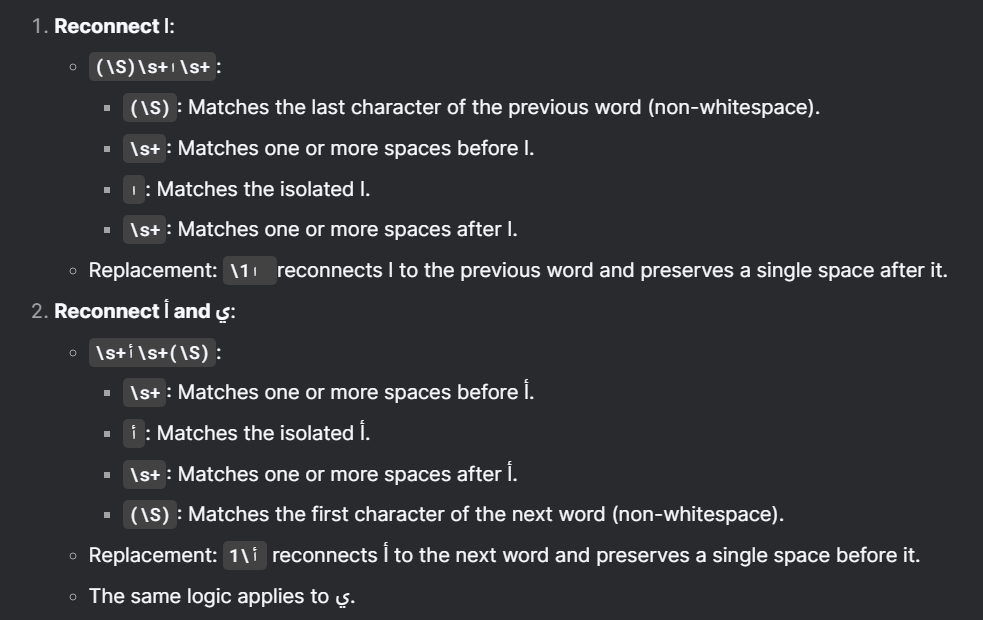

## Tokenization

In [42]:
import sentencepiece
print("SentencePiece version:", sentencepiece.__version__)

SentencePiece version: 0.2.0


In [43]:
# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [44]:
# Example Arabic text
text = "هذا نص تجريبي"

# Tokenize the text
encoded = tokenizer.tokenize(text)
# encoded = tokenizer.convert_tokens_to_string(encoded)
print("text after tokenize: ", encoded)

# Tokenize the text without padding
input_ids = tokenizer.encode(text, max_length=512, truncation=True, padding=False)
print("Token IDs (no padding):", input_ids)

# Decode token IDs back to text (skip special tokens)
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
print("Decoded Text:", decoded_text)

text after tokenize:  ['▁', 'هذا', '▁', 'نص', '▁', 'تجريبي']
Token IDs (no padding): [3, 2, 3, 2, 3, 2, 1]
Decoded Text: 


In [45]:
arabic_text = "هذا نص تجريبي"
tokens = tokenizer.tokenize(arabic_text)
print("Tokens:", tokens)

# Check if any tokens are unknown
unknown_tokens = [token for token in tokens if tokenizer.convert_tokens_to_ids(token) == 3]
print("Unknown Tokens:", unknown_tokens)

for token in tokens:
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"Token: {token}, Token ID: {token_id}")
    
vocab = tokenizer.get_vocab()
print("Vocabulary Size:", len(vocab))

# Check if some Arabic tokens exist in the vocabulary
arabic_tokens = ["ه", "ذا", "نص", "تجريبي"]
for token in arabic_tokens:
    if token in vocab:
        print(f"Token '{token}' found in vocabulary with ID: {vocab[token]}")
    else:
        print(f"Token '{token}' NOT found in vocabulary.")

Tokens: ['▁', 'هذا', '▁', 'نص', '▁', 'تجريبي']
Unknown Tokens: ['▁', '▁', '▁']
Token: ▁, Token ID: 3
Token: هذا, Token ID: 2
Token: ▁, Token ID: 3
Token: نص, Token ID: 2
Token: ▁, Token ID: 3
Token: تجريبي, Token ID: 2
Vocabulary Size: 32100
Token 'ه' NOT found in vocabulary.
Token 'ذا' NOT found in vocabulary.
Token 'نص' NOT found in vocabulary.
Token 'تجريبي' NOT found in vocabulary.


after trying t5 tokenizer (small), it seems that this model has not trained enough on arabic words, it doesn't recognize it

In [46]:
from transformers import AutoTokenizer,MT5Tokenizer

# Initialize AraBERT tokenizer
arabert_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
t5_mutli_tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")

# Example Arabic text
arabic_text = "هذا نص تجريبي"

# Tokenize the text
araber_tokens = arabert_tokenizer.tokenize(arabic_text)
t5_tokens = t5_mutli_tokenizer.tokenize(arabic_text)
print("Arabic Bert Tokens:", araber_tokens)
print("T5 Tokens:", t5_tokens)

# Encode the text
arabert_input_ids = arabert_tokenizer.encode(arabic_text, max_length=512, truncation=True, padding=False)
t5_input_ids = t5_mutli_tokenizer.encode(arabic_text, max_length=512, truncation=True, padding=False)
print("Arabic Bert Token IDs:", arabert_input_ids)
print("T5 Token IDs:", t5_input_ids)

# Decode token IDs back to text
arabert_decoded_text = arabert_tokenizer.decode(arabert_input_ids, skip_special_tokens=True)
t5_decoded_text = t5_mutli_tokenizer.decode(t5_input_ids, skip_special_tokens=True)
print("Arabic Bert Decoded Text:", arabert_decoded_text)
print("T5 Decoded Text:", t5_decoded_text)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Arabic Bert Tokens: ['هذا', 'نص', 'تجريبي']
T5 Tokens: ['▁', 'هذا', '▁نص', '▁تجر', 'يبي']
Arabic Bert Token IDs: [33, 387, 1170, 7928, 34]
T5 Token IDs: [259, 2820, 14165, 136419, 93460, 1]
Arabic Bert Decoded Text: هذا نص تجريبي
T5 Decoded Text: هذا نص تجريبي


both models seems to be good at tokenizing the arabic, but arabic bert is better at tokenizing the words than T5 as it seems from the output 

In [47]:
# tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

In [48]:
def AraBert_tokenizer(text, max_length=512, padding="max_length", truncation=True):
    
    tokenized_output = tokenizer(
        text,
        max_length=max_length,
        padding=padding,
        truncation=truncation,
        return_tensors="pt"  # Return PyTorch tensors
    )
    return tokenized_output

## Apply Functions on the text

In [49]:
df_squad.head(10)

,question,context,answers,c_id
0,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0
1,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0
2,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0
3,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0
4,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0
5,لماذا تم ترميز الرمز بحيث تكون معظم الرموز معًا؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': 'لسهولة تحديد الهوية', 'answer_start...",1
6,كم عدد المراكز في العمودين الأولين؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '32 موضع', 'answer_start': 128}]",1
7,ما الذي قررت اللجنة أنه مهم؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,[{'text': 'دعم الأحرف الهجائية الكبيرة المكونة...,1
8,أين كان الحرف ألف يضع في الموقف؟,تم تزيين الرمز نفسه بحيث تكون معظم رموز التحكم...,"[{'text': '41hex', 'answer_start': 757}]",1
9,تم دمج ASCII في ما مجموعة الأحرف الأخرى؟,تم دمج ASCII في مجموعة أحرف ونيكودي كأول 128 ر...,"[{'text': 'ونيكودي', 'answer_start': 28}]",2


In [50]:
# TODO: 2 approaches to be taken on the datasets:
#              1- apply the fixme changes to squad data
#              Done
#              2- try the nlp preprocessing techniques to the other datasets (arcd, tydiqa, mlqa) and see if there any problems in them

### Questions column

In [51]:
df_squad['processed_question'] = df_squad['question'].apply(remove_diacritics).apply(fix_arabic_spacing).apply(remove_extra_spaces).apply(remove_punk).apply(remove_alef_variations)

* i tried to apply text clean function but i think it made some question not understandable

In [52]:
df_squad['processed_question'].head(10)

0                              ما هو ASCII على اساس
1               كم شخصيات محددة موجودة في كود ASCII
2                    كم عدد احرف التحكم غير الطباعة
3                           كم شخصيات قابلة للطباعة
4               ما هو الفضاء المعروف ايضا باسم ماذا
5    لماذا تم ترميز الرمز بحيث تكون معظم الرموز معا
6                كم عدد المراكز في العمودين الاولين
7                       ما الذي قررت اللجنة انه مهم
8                   اين كان الحرف الف يضع في الموقف
9           تم دمج ASCII في ما مجموعة الاحرف الاخرى
Name: processed_question, dtype: object

In [53]:
## to check if there ? in every question or not
# list = []
# for i in range(len(df_squad['question'])):
#     c = df_squad['question'][i].count('؟')
#     list.append(c)
#     # print(df_squad['question'][0])
# list

### Context column

In [54]:
# TODO: First see what preprocessing techniques we will use for the text for questions, contexts, answers(only text cleaning(i think))
# Done

# FIXME: Squad data is cleaned from the diacritics and been replaced with space, how to fix:
#           1- combine every ا to its previous word as the original word but some words may corrupt
#           2- combine every ى and أ with next word when coming in first
#           3- remove every alone character but this also maya corrupt some words as some words splitted from the diacritics (except for ب, ك and و)
# Fixed 

In [112]:
# remove the extra spacing between letters problem
df_squad['processed_context'] = df_squad['context'].apply(fix_arabic_spacing)

In [113]:
# remove extra spaces between words
df_squad['processed_context'] = df_squad['processed_context'].apply(remove_extra_spaces)

In [114]:
# remove punctuation from words
df_squad['processed_context'] = df_squad['processed_context'].apply(remove_punk)

In [115]:
# remove Alef variation from contexts
df_squad['processed_context'] = df_squad['processed_context'].apply(remove_alef_variations)

In [116]:
df_squad['processed_context'][df_squad['c_id'] == 543].tolist()[0]

'ولانه كان من اتباع القضية المطلقة  فقد لعب اليو دورا مهما في قمع مؤيدي دستور عام 1812  ولهذا السبب  ق بض عليه في عام 1820 وتم اعدامه في عام 1822 من قبل جاروت  استمر الصراع بين الحكم المطلق والليبراليين  وفي فترة الحكم المحافظ الذي اطلق عليه العقد الشنيع 1823 1833  والذي اعقب ترينيو ليبرالي  كان هناك قمع لا يرحم من قبل القوات الحكومية ومحاكم التفتيش الكاثوليكية  اخر ضحية لمحاكمة التفتيش كان غيتا ريبولي  وهو مدرس متهم بكونه ربوبيا وماسون تم شنقه في فالنسيا عام 1824 '

In [117]:
unique_contexts_df = pd.DataFrame(df_squad['context'].unique().tolist(), columns=["unique context"])
unique_contexts_df.to_csv("unique_context.csv", index=False, header=True)

### Answers column

In [118]:
df_squad['processed_answers'] = df_squad['answers'].apply(remove_diacritics).apply(fix_arabic_spacing).apply(remove_extra_spaces).apply(remove_punk).apply(remove_alef_variations)

In [119]:
df_squad.head()

,question,context,answers,c_id,processed_question,processed_context,processed_answers
0,ما هو ASCII على أساس؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'الأبجدية الإنجليزية', 'answer_start...",0,ما هو ASCII على اساس,يعتمد ASCII اساسا على الابجدية الانجليزية ويق...,[text الابجدية الانجليزية answerstart 23]
1,كم شخصيات محددة موجودة في كود ASCII؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '128 حرف ا محدد', 'answer_start': 58}]",0,كم شخصيات محددة موجودة في كود ASCII,يعتمد ASCII اساسا على الابجدية الانجليزية ويق...,[text 128 حرفا محدد answerstart 58]
2,كم عدد أحرف التحكم غير الطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '33 حرف ا تحكم ا غير الطباعة', 'answ...",0,كم عدد احرف التحكم غير الطباعة,يعتمد ASCII اساسا على الابجدية الانجليزية ويق...,[text 33 حرفا تحكما غير الطباعة answerstart 405]
3,كم شخصيات قابلة للطباعة؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': '95 حرف ا قابلا للطباعة', 'answer_st...",0,كم شخصيات قابلة للطباعة,يعتمد ASCII اساسا على الابجدية الانجليزية ويق...,[text 95 حرفا قابلا للطباعة answerstart 494]
4,ما هو الفضاء المعروف أيضا باسم ماذا؟,يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، و...,"[{'text': 'رسم ا غير مرئي 223', 'answer_start'...",0,ما هو الفضاء المعروف ايضا باسم ماذا,يعتمد ASCII اساسا على الابجدية الانجليزية ويق...,[text رسما غير مرئي 223 answerstart 550]


# Prepare the data for Train

In [120]:
def preprocess_dataset(dataset):
    preprocessed_data = []
    
    for example in dataset:
        # Skip empty examples
        if not example["context"] or not example["question"] or not example["answers"]:
            continue
        
        # Tokenize the input (context)
        inputs = tokenizer(
            example["context"],
            max_length=512,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        # Tokenize the target (question and answer)
        labels = tokenizer(
            example["question"] + " " + example["answers"],
            max_length=128,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        # Check for invalid token IDs
        if (inputs["input_ids"] >= tokenizer.vocab_size).any() or (labels["input_ids"] >= tokenizer.vocab_size).any():
            continue  # Skip invalid examples
        
        # Append preprocessed data
        preprocessed_data.append({
            "input_ids": inputs["input_ids"].squeeze(),  # Remove batch dimension
            "attention_mask": inputs["attention_mask"].squeeze(),  # Remove batch dimension
            "labels": labels["input_ids"].squeeze()  # Remove batch dimension
        })
    
    return preprocessed_data

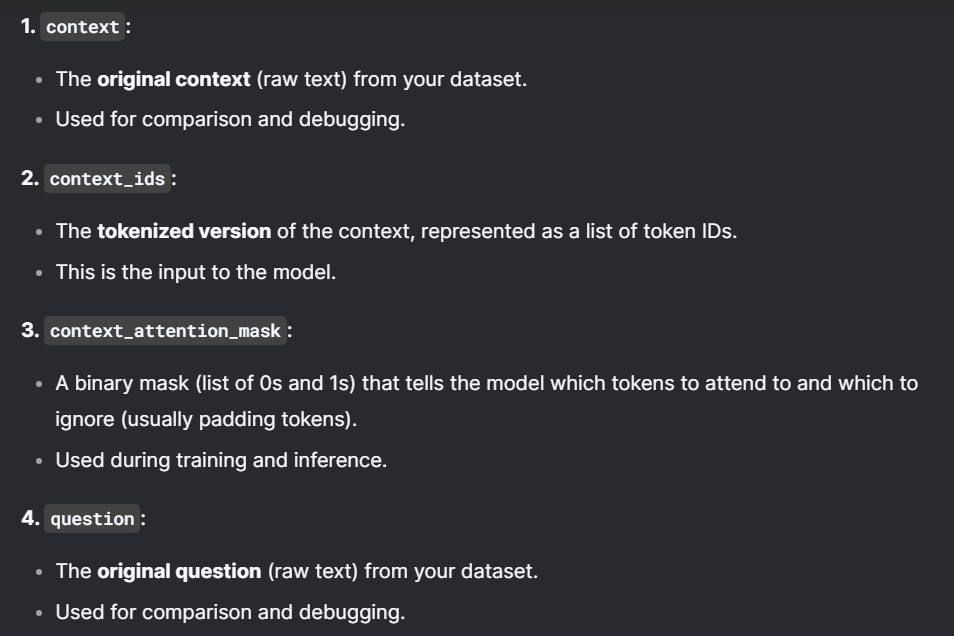
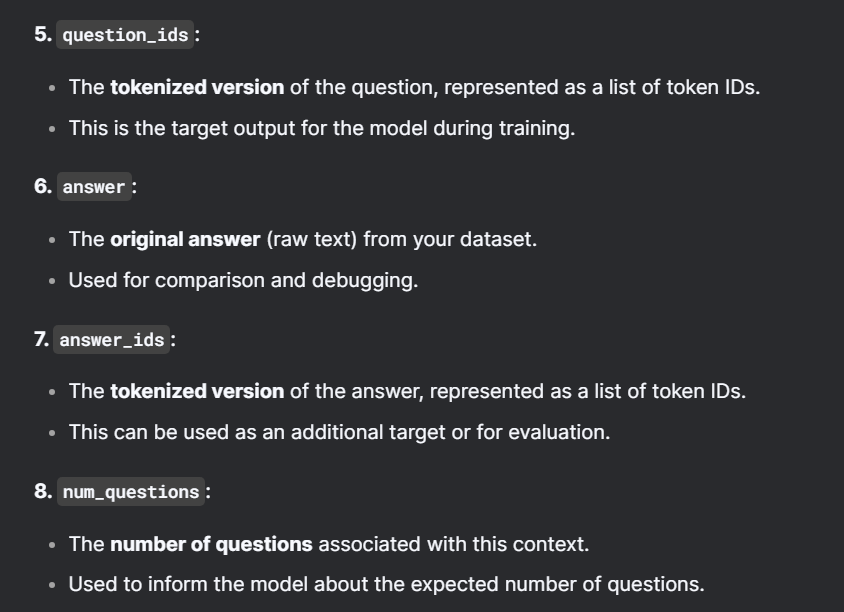

In [121]:
# Split by context_id to avoid data leakage
context_ids = df_squad["c_id"].unique()
train_ids, test_ids = train_test_split(context_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

# Create splits
train_data = df_squad[df_squad["c_id"].isin(train_ids)].to_dict("records")
val_data = df_squad[df_squad["c_id"].isin(val_ids)].to_dict("records")
test_data = df_squad[df_squad["c_id"].isin(test_ids)].to_dict("records")

# Preprocess each split
train_processed = preprocess_dataset(train_data)
val_processed = preprocess_dataset(val_data)
test_processed = preprocess_dataset(test_data)

In [122]:
# # Compare the first 5 examples
# for i, example in enumerate(train_processed[:3], 1):
#     # Extract the original context and decoded context
#     original_context = train_data.iloc[i - 1]["processed_context"]
#     decoded_context = example["context"]
    
#     # Print and compare
#     print(f"Example {i}:")
#     print("Decoded Context:", decoded_context)
#     print("Original Context:", original_context)
    
#     # Check if they match
#     if decoded_context == original_context:
#         print("The contexts match!")
#     else:
#         print("The contexts DO NOT match!")
#     print("-" * 50)

# Model

In [3]:
# TODO:
#       1- try T5 Medium model -> see what the vocab size of the model and compare it with the tokenizer (t5 tokenizer is 64000, AraBert tokenizer is 250100)
#       2- try AraBert model -> see what the vocab size of the model as it may be bigger than T5
#       3- try to make the model limit bigger than its original limit -> adjust the size of the model to be equal to the tokenizer vocab size

In [4]:
# load the model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

In [ ]:
# Resize the model's embedding layer
model.resize_token_embeddings(len(tokenizer))

# Verify the new vocabulary size
print("New model vocabulary size:", model.config.vocab_size)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


New model vocabulary size: 64000


In [124]:
# from transformers import T5Tokenizer

# Initialize T5 tokenizer
# tokenizer = T5Tokenizer.from_pretrained("t5-small")

## small example

In [129]:
import torch

# Example: Extract a batch of data
batch = train_processed[:8]  # First 8 examples

# Extract input IDs, attention masks, and labels
input_ids = [example["input_ids"] for example in batch]
attention_masks = [example["attention_mask"] for example in batch]
labels = [example["labels"] for example in batch]

# Stack the tensors
input_ids = torch.stack(input_ids)
attention_masks = torch.stack(attention_masks)
labels = torch.stack(labels)

# Now you can feed these tensors into the model
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)
print("Labels shape:", labels.shape)

Input IDs shape: torch.Size([8, 512])
Attention Masks shape: torch.Size([8, 512])
Labels shape: torch.Size([8, 128])


In [130]:
# Get the vocab size of your tokenizer
vocab_size = tokenizer.vocab_size
print("Tokenizer vocab size:", vocab_size)

# Check if any token ID is out of range
max_token_id = max(max(example["input_ids"]) for example in train_processed)
print("Max token ID in dataset:", max_token_id)

if max_token_id >= vocab_size:
    print("Error: Some token IDs exceed the vocabulary size!")

Tokenizer vocab size: 250100
Max token ID in dataset: tensor(238564)


In [131]:
# Check the first example in train_processed
example = train_processed[0]
print("Input IDs:", example["input_ids"])
print("Labels:", example["labels"])

# Check for invalid token IDs
invalid_input_ids = [token_id for token_id in example["input_ids"] if token_id >= tokenizer.vocab_size]
invalid_labels = [token_id for token_id in example["labels"] if token_id >= tokenizer.vocab_size]

print("Invalid input IDs:", invalid_input_ids)
print("Invalid labels:", invalid_labels)

Input IDs: tensor([  5323,    550,  56747, 116682,   5523,    575,    259,  24689,   1021,
         29726,    341,  36965, 117421,   3510,   3595,   3904,  13284,    259,
         30829,    858,    259,    343,  16259,   8871,   6238,  48345,   1021,
         29726, 116682,   5523,  57432,  42414,    556,    617,  14051,    722,
           259,    942,  13950,   6531,  76498,    259, 119143,  11124,    575,
        117529,    402,  44098,  21105,    259,    260,  40047,  39103,    259,
          2820,    259,    572,   2218,    259, 128728,    630,  41357,  24110,
          1491, 116682,   5523,    617,  78199,    259,    343,   1240,   8871,
          1412,    548,  12908,    259, 128728,    630,    259,   4237,  17824,
         48345,    259,    942,   1021,  29726, 116682,   5523,   1189,  10790,
          8764,  17629,   4239,  12908, 116682,   5523,    259,   4237,  17824,
         48345,    259,    942,  13950,    766,  35598,   2578,  29726,    259,
           260,  19301,   259

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_processed,
    eval_dataset=val_processed,
)

# Train the model
trainer.train()

c:\Users\Mohammed237\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
